In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

### Data prep before running

In [2]:
!pwd

/Users/lisacombs/Documents/FALL2019/INTRO_DS/Project/notebooks


In [3]:
data = pd.read_csv('/Users/lisacombs/Documents/FALL2019/INTRO_DS/Project/clean_data/vegas_cuisine.csv')
data.shape

(3779, 422)

In [4]:
empty = ['AcceptsInsurance',
 'ByAppointmentOnly',
 'RestaurantsPriceRange2',
 'Music_background_music',
 'Music_karaoke',
 'Music_live',
 'Music_jukebox',
 'Ambience_romantic',
 'Ambience_intimate',
 'Ambience_classy',
 'Ambience_hipster',
 'Ambience_divey',
 'Ambience_touristy',
 'Ambience_trendy',
 'Ambience_upscale',
 'Ambience_casual',
 'RestaurantsGoodForGroups',
 'Open24Hours',
 'BYOBCorkage',
 'Corkage',
 'DietaryRestrictions_dairy-free',
 'BusinessAcceptsCreditCards',
 'BusinessParking_garage',
 'GoodForKids',
 'WheelchairAccessible',
 'BikeParking',
 'Alcohol',
 'HasTV',
 'NoiseLevel',
 'RestaurantsAttire',
 'Music_dj',
 'Music_no_music',
 'Music_video',
 'Caters',
 'WiFi',
 'RestaurantsReservations',
 'RestaurantsTakeOut',
 'HappyHour',
 'GoodForDancing',
 'RestaurantsTableService',
 'OutdoorSeating',
 'RestaurantsDelivery',
 'BestNights_monday',
 'BestNights_tuesday',
 'BestNights_friday',
 'BestNights_wednesday',
 'BestNights_thursday',
 'BestNights_sunday',
 'BestNights_saturday',
 'GoodForMeal_dessert',
 'GoodForMeal_latenight',
 'GoodForMeal_lunch',
 'GoodForMeal_dinner',
 'GoodForMeal_breakfast',
 'GoodForMeal_brunch',
 'CoatCheck',
 'Smoking',
 'DriveThru',
 'DogsAllowed',
 'BusinessAcceptsBitcoin',
 'BYOB',
 'DietaryRestrictions_gluten-free',
 'DietaryRestrictions_vegan',
 'DietaryRestrictions_kosher',
 'DietaryRestrictions_halal',
 'DietaryRestrictions_soy-free',
 'DietaryRestrictions_vegetarian',
 'AgesAllowed',
 'RestaurantsCounterService']

len(empty)

datanew = data
datanew.replace(0.5, 0, inplace=True) #may comment this out
cols = [col for col in datanew.columns if col not in empty]
datause = datanew[cols]
datause.columns
summary= datause.describe()
empty2 = []
features_use = summary.columns.tolist()

for i in features_use:
  if summary.loc['max',i] == 0:
      empty2.append(i)

len(empty2)
cols_nonnull = [col for col in datause.columns if col not in empty2]
datafinal = datause[cols_nonnull]

summary = datafinal.describe()
summary

important = []
features_use = summary.columns.tolist()
for i in features_use:
  if summary.loc['mean',i] > 0.01:
      important.append(i)

important_cols = important[7:48]

In [5]:
X = datafinal[important_cols]
Y = datafinal['success']

In [6]:
X.shape

(3779, 41)

In [7]:
X.columns.tolist()

['BusinessParking_street',
 'BusinessParking_validated',
 'BusinessParking_valet',
 'class',
 'Arts & Entertainment',
 'Asian Fusion',
 'Bakeries',
 'Barbeque',
 'Bars',
 'Beer',
 'Breakfast & Brunch',
 'Buffets',
 'Cafes',
 'Casinos',
 'Caterers',
 'Cocktail Bars',
 'Coffee & Tea',
 'Desserts',
 'Diners',
 'Event Planning & Services',
 'Food',
 'Food Delivery Services',
 'Food Stands',
 'Food Trucks',
 'Gluten-Free',
 'Grocery',
 'Hawaiian',
 'Ice Cream & Frozen Yogurt',
 'Juice Bars & Smoothies',
 'Lounges',
 'Nightlife',
 'Pubs',
 'Restaurants',
 'Salad',
 'Seafood',
 'Shopping',
 'Soup',
 'Specialty Food',
 'Sports Bars',
 'Steakhouses',
 'Sushi Bars']

In [8]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, train_size = 0.75)

### First Run {no optimization, no feature selection}
#### Base Model

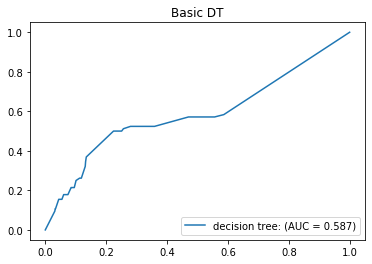

In [9]:
clf = DecisionTreeClassifier()
clf = clf.fit(Xtrain, ytrain)
dt_predict = clf.predict_proba(Xtest)[:,1]
dt_fpr, dt_tpr, thresholds = roc_curve(ytest, dt_predict)
dt_roc_auc = auc(dt_fpr, dt_tpr)

plt.plot(dt_fpr, dt_tpr, label = 'decision tree: (AUC = %0.3f)' % dt_roc_auc)
plt.title('Basic DT')
plt.legend(loc="lower right")

### Optimization 1
To avoid overfitting, change minimum number of samples in a leaf node (min_samples_leaf) or maximum depth of the tree (max_depth) and do a cross validation to find optimal number for them.

In [10]:
# expo_numbers_unformatted = np.logspace(1, 12, num=10, endpoint=True, base=2, dtype=None, axis=0)
# expo_numbers = []

# for number in expo_numbers_unformatted:
#     number = int(number)
#     expo_numbers.append(number)

# print(expo_numbers)

In [11]:
rg_grid = DecisionTreeClassifier()
max_depth_range = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_leaf_range = [1, 2, 4, 8, 10]
param_grid = dict(max_depth=max_depth_range, min_samples_leaf = min_samples_leaf_range)

kfold = KFold(n_splits=10, shuffle=True, random_state=1)
grid = GridSearchCV(rg_grid, param_grid, cv = kfold, scoring = 'roc_auc')
grid.fit(Xtrain, ytrain)

print('Best AUC and parameters:')
print(grid.best_score_, grid.best_params_)

Best AUC and parameters:
0.732753578028989 {'max_depth': 110, 'min_samples_leaf': 10}


### Optimization 1

In [12]:
clf_opt = DecisionTreeClassifier(max_depth = grid.best_params_.get('max_depth'), min_samples_leaf = grid.best_params_.get('min_samples_leaf'))
clf_opt = clf_opt.fit(Xtrain, ytrain)

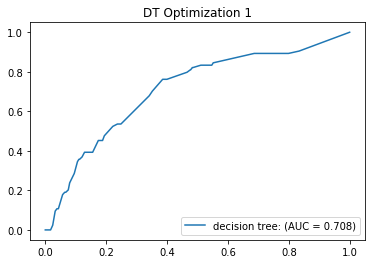

In [13]:
dt_predict_opt = clf_opt.predict_proba(Xtest)[:,1]
dt_fpr_opt, dt_tpr_opt, thresholds = roc_curve(ytest, dt_predict_opt)
dt_roc_auc_opt = auc(dt_fpr_opt, dt_tpr_opt)

plt.plot(dt_fpr_opt, dt_tpr_opt, label = 'decision tree: (AUC = %0.3f)' % dt_roc_auc_opt)
plt.title('DT Optimization 1')
plt.legend(loc="lower right")

In [14]:
feature_importance_basic = clf.feature_importances_
len(feature_importance_basic)

41

In [15]:
numOfImportantFeature_basic = np.count_nonzero(feature_importance_basic)
numOfImportantFeature_basic

40

In [16]:
feature_importance = clf_opt.feature_importances_
len(feature_importance)

41

In [17]:
numOfImportantFeature = np.count_nonzero(feature_importance)
numOfImportantFeature

34

In [18]:
important_features = np.argsort(feature_importance)
important_features = important_features[-numOfImportantFeature:]
important_features

array([21, 35, 29, 19, 23, 27, 18,  0, 31, 11,  6,  4, 16, 30, 33,  7, 36,
        9, 38, 14, 34, 15, 37, 12, 40, 10, 20, 17,  3,  8, 39,  1,  5,  2])

In [19]:
cols_dt = [X.columns[i] for i in important_features]
cols_dt

['Food Delivery Services',
 'Shopping',
 'Lounges',
 'Event Planning & Services',
 'Food Trucks',
 'Ice Cream & Frozen Yogurt',
 'Diners',
 'BusinessParking_street',
 'Pubs',
 'Buffets',
 'Bakeries',
 'Arts & Entertainment',
 'Coffee & Tea',
 'Nightlife',
 'Salad',
 'Barbeque',
 'Soup',
 'Beer',
 'Sports Bars',
 'Caterers',
 'Seafood',
 'Cocktail Bars',
 'Specialty Food',
 'Cafes',
 'Sushi Bars',
 'Breakfast & Brunch',
 'Food',
 'Desserts',
 'class',
 'Bars',
 'Steakhouses',
 'BusinessParking_validated',
 'Asian Fusion',
 'BusinessParking_valet']

In [20]:
fi = pd.DataFrame({'feature': list(Xtrain.columns),
                   'importance': feature_importance}).\
                    sort_values('importance', ascending = False)
print(fi.head())

                      feature  importance
2       BusinessParking_valet    0.175213
5                Asian Fusion    0.130503
1   BusinessParking_validated    0.076038
39                Steakhouses    0.066520
8                        Bars    0.065198


### Optimization 2

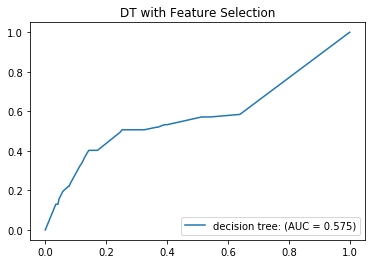

In [21]:
newX = datafinal[cols_dt]
Y = datafinal['success']

newXtrain, Xtest, ytrain, ytest = train_test_split(newX, Y, train_size = 0.75)
clf_fs = DecisionTreeClassifier()
clf_fs = clf_fs.fit(newXtrain, ytrain)

dt_predict = clf_fs.predict_proba(Xtest)[:,1]
dt_fpr, dt_tpr, thresholds = roc_curve(ytest, dt_predict)
dt_roc_auc = auc(dt_fpr, dt_tpr)

plt.plot(dt_fpr, dt_tpr, label = 'decision tree: (AUC = %0.3f)' % dt_roc_auc)
plt.title('DT with Feature Selection')
plt.legend(loc="lower right")

In [22]:
rg_grid = DecisionTreeClassifier()
max_depth_range = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_leaf_range = [1, 2, 4, 8, 10]
param_grid = dict(max_depth=max_depth_range, min_samples_leaf = min_samples_leaf_range)

kfold = KFold(n_splits=10, shuffle=True, random_state=1)
grid2 = GridSearchCV(rg_grid, param_grid, cv = kfold, scoring = 'roc_auc')
grid2.fit(newXtrain, ytrain)
print ('Best AUC and parameters:')
print (grid2.best_score_, grid2.best_params_)

Best AUC and parameters:
0.7093903814062964 {'max_depth': 40, 'min_samples_leaf': 10}


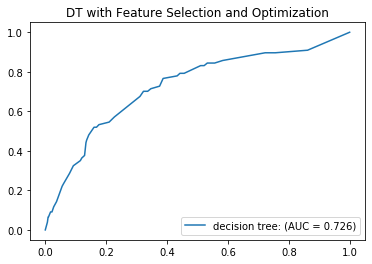

In [23]:
# Third Run {with feature selection and Optimization 2}

clf_opt2 = DecisionTreeClassifier(max_depth = grid2.best_params_.get('max_depth'), min_samples_leaf = grid2.best_params_.get('min_samples_leaf'))
clf_opt2 = clf_opt2.fit(newXtrain, ytrain)
feature_importance2 = clf_opt2.feature_importances_
dt_predict_opt2 = clf_opt2.predict_proba(Xtest)[:,1]
dt_fpr_opt2, dt_tpr_opt2, thresholds = roc_curve(ytest, dt_predict_opt2)
dt_roc_auc_opt2 = auc(dt_fpr_opt2, dt_tpr_opt2)

plt.plot(dt_fpr_opt2, dt_tpr_opt2, label = 'decision tree: (AUC = %0.3f)' % dt_roc_auc_opt2)
plt.title('DT with Feature Selection and Optimization')
plt.legend(loc="lower right")

In [24]:
fi_e = pd.DataFrame({'Feature': list(newXtrain.columns),
                   'Importance': feature_importance2}).\
                    sort_values('Importance', ascending = False)
print(fi_e.head(20))

                      Feature  Importance
33      BusinessParking_valet    0.186635
32               Asian Fusion    0.095154
27                   Desserts    0.094399
24                 Sushi Bars    0.083384
28                      class    0.078273
31  BusinessParking_validated    0.052709
30                Steakhouses    0.050280
25         Breakfast & Brunch    0.050249
26                       Food    0.046456
20                    Seafood    0.042881
29                       Bars    0.034536
22             Specialty Food    0.032079
6                      Diners    0.022434
21              Cocktail Bars    0.020451
23                      Cafes    0.020421
10                   Bakeries    0.014307
12               Coffee & Tea    0.013989
13                  Nightlife    0.011195
15                   Barbeque    0.009503
7      BusinessParking_street    0.008411


### Decision Tree vizualization

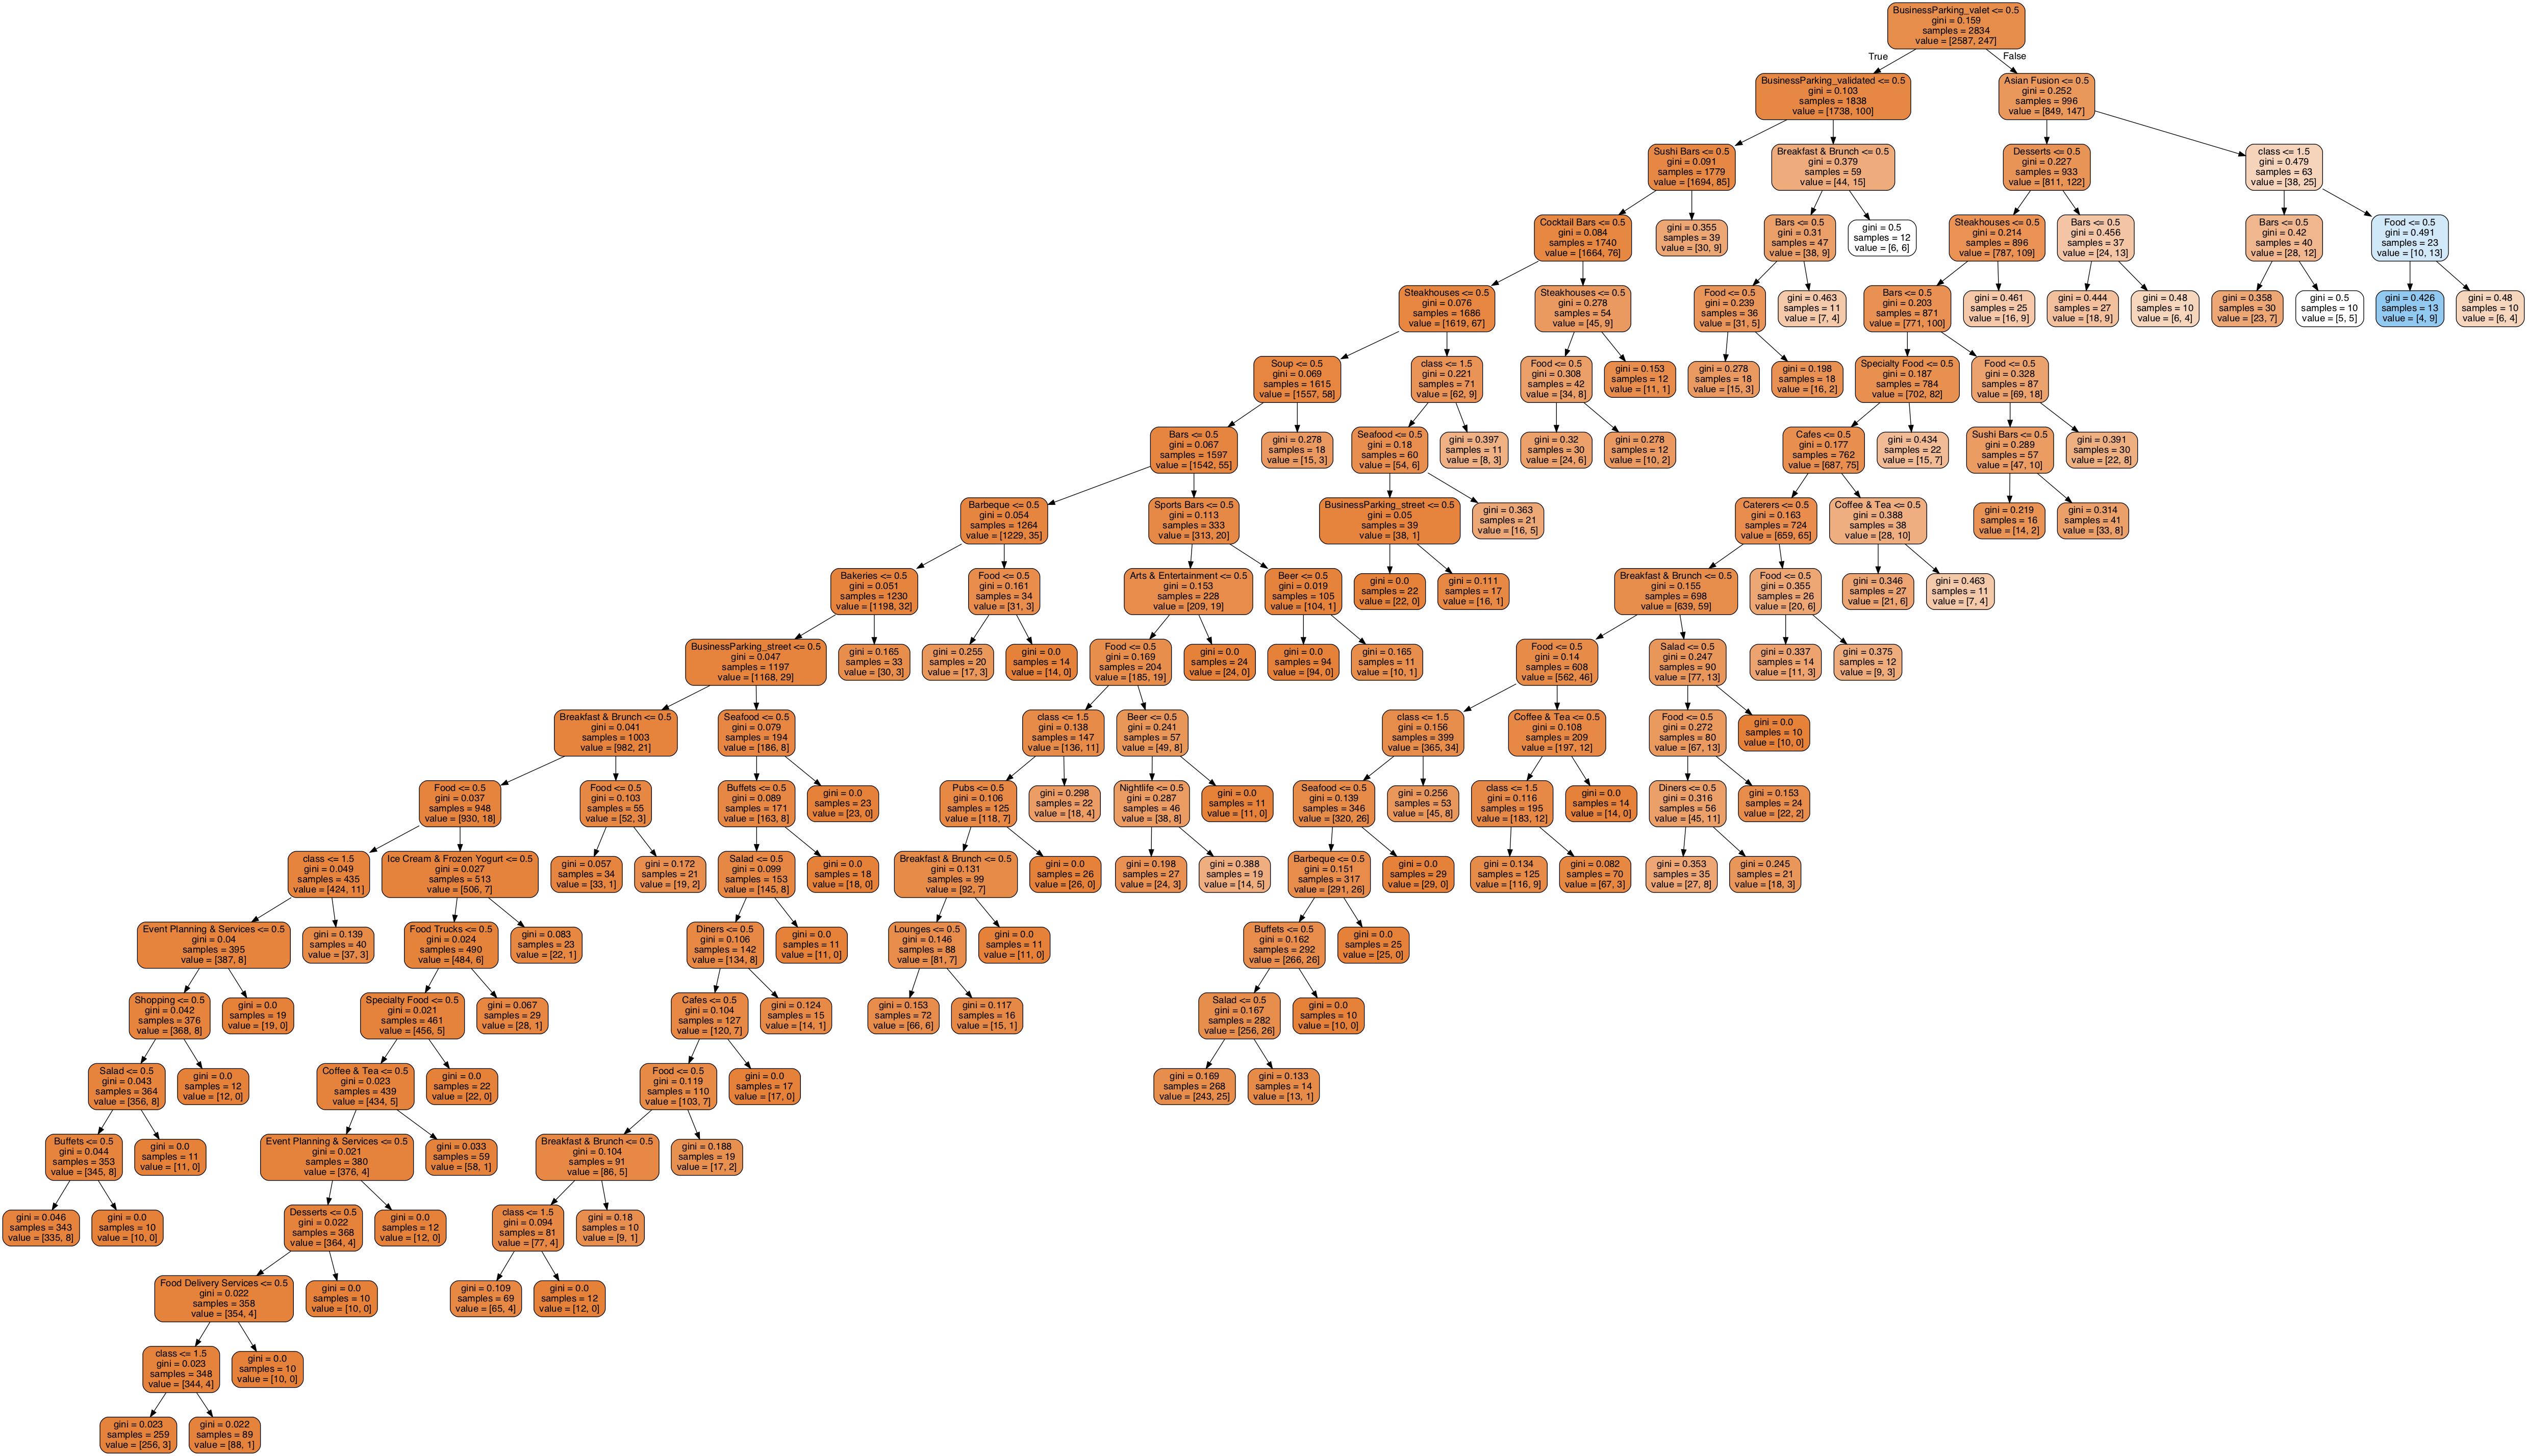

In [25]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(clf_opt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=False, feature_names=Xtrain.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())

## Random Forest

In [26]:
X = datafinal[important_cols]
Y = datafinal['success']
Xtrain_rf, Xtest_rf, ytrain_rf, ytest_rf = train_test_split(X, Y, train_size = 0.75)

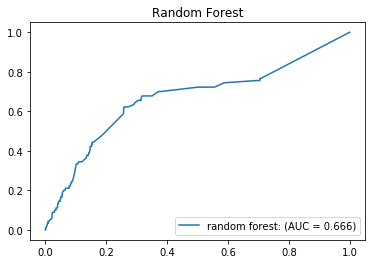

In [27]:
rf = RandomForestClassifier()
rf = rf.fit(Xtrain_rf, ytrain_rf)
rf_predict = rf.predict_proba(Xtest_rf)[:,1]
rf_fpr, rf_tpr, thresholds = roc_curve(ytest_rf, rf_predict)
rf_roc_auc = auc(rf_fpr, rf_tpr)

plt.plot(rf_fpr, rf_tpr, label = 'random forest: (AUC = %0.3f)' % rf_roc_auc)
plt.title('Random Forest')
plt.legend(loc="lower right")

In [28]:
feature_importance_rf = rf.feature_importances_
numOfImportantFeature_rf = np.count_nonzero(feature_importance_rf)
print("Number of important features: ")
print(numOfImportantFeature_rf)
important_features_rf = np.argsort(feature_importance_rf)
important_features_rf[-numOfImportantFeature_rf:]
importantCols_rf = [data.columns[i + 16] for i in important_features_rf[-numOfImportantFeature_rf:]]
print("Important Columns:")
print(importantCols_rf)
fi_e = pd.DataFrame({'Feature': list(Xtrain_rf.columns),
                   'Importance': feature_importance_rf}).\
                    sort_values('Importance', ascending = False)
print(fi_e.head(20))

Number of important features: 
41
Important Columns:
['GoodForMeal_lunch', 'Music_dj', 'BusinessParking_lot', 'GoodForMeal_latenight', 'GoodForMeal_brunch', 'HappyHour', 'BestNights_friday', 'DriveThru', 'BestNights_monday', 'NoiseLevel', 'BestNights_saturday', 'GoodForDancing', 'Caters', 'RestaurantsDelivery', 'CoatCheck', 'BestNights_thursday', 'BestNights_tuesday', 'BestNights_sunday', 'WiFi', 'GoodForKids', 'OutdoorSeating', 'RestaurantsAttire', 'Alcohol', 'BestNights_wednesday', 'GoodForMeal_dinner', 'Smoking', 'WheelchairAccessible', 'BikeParking', 'BusinessAcceptsBitcoin', 'RestaurantsReservations', 'DogsAllowed', 'BusinessAcceptsCreditCards', 'GoodForMeal_breakfast', 'GoodForMeal_dessert', 'BusinessParking_valet', 'HasTV', 'RestaurantsTakeOut', 'BusinessParking_garage', 'RestaurantsTableService', 'BusinessParking_validated', 'BusinessParking_street']
                      Feature  Importance
2       BusinessParking_valet    0.067919
3                       class    0.066405
20 

In [29]:
from pprint import pprint
# Look at parameters used by our current forest

print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [30]:
n_nodes = []
max_depths = []

for ind_tree in rf.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 668
Average maximum depth 31


In [31]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [32]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(Xtrain_rf, ytrain_rf)

# Note: may take a few minutes to run.

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.1min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=10,
                                                    n_jobs=None,
  

In [33]:
rf_random.best_params_

{'n_estimators': 1200,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': True}

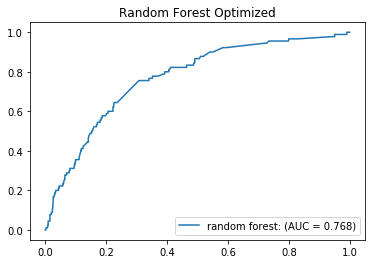

In [34]:
rf1 = RandomForestClassifier(max_depth= rf_random.best_params_.get('max_depth'), 
                             min_samples_leaf=rf_random.best_params_.get('min_samples_leaf'), 
                             min_samples_split=rf_random.best_params_.get('min_samples_split'), 
                             n_estimators=rf_random.best_params_.get('n_estimators'))
rf1 = rf1.fit(Xtrain_rf, ytrain_rf)
rf_predict1 = rf1.predict_proba(Xtest_rf)[:,1]
rf_fpr, rf_tpr, thresholds = roc_curve(ytest_rf, rf_predict1)
rf_roc_auc = auc(rf_fpr, rf_tpr)

plt.plot(rf_fpr, rf_tpr, label = 'random forest: (AUC = %0.3f)' % rf_roc_auc)
plt.title('Random Forest Optimized')
plt.legend(loc="lower right")

In [35]:
n_nodes = []
max_depths = []

for ind_tree in rf1.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 217
Average maximum depth 19


### Logistic Regression

First Run

In [36]:
#Xtrain_lr, Xtest_lr, ytrain_lr, ytest_lr = train_test_split(X, Y, train_size = 0.75)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, train_size = 0.75)

Accuracy of logistic regression classifier on test set: 0.89


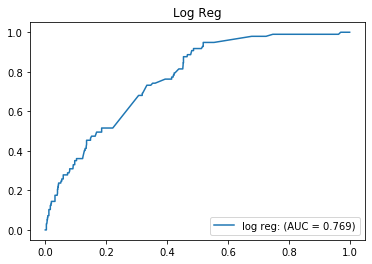

In [37]:
lr = LogisticRegression()
lr.fit(Xtrain, ytrain)
y_pred = lr.predict(Xtest)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(Xtest, ytest)))

lr_predict = lr.predict_proba(Xtest)[:,1]
lr_fpr, lr_tpr, thresholds = roc_curve(ytest, lr_predict)
lr_roc_auc = auc(lr_fpr, lr_tpr)

plt.plot(lr_fpr, lr_tpr, label = 'log reg: (AUC = %0.3f)' % lr_roc_auc)
plt.title('Log Reg')
plt.legend(loc="lower right")

### Log Reg: Test

(With feature selection)

In [38]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, train_size = 0.75, random_state = 0)

Accuracy of logistic regression classifier on test set: 0.92


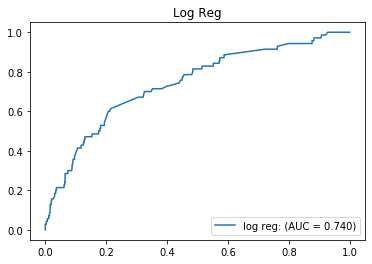

In [39]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(Xtrain, ytrain) # feature importances from decision tree
y_pred = lr.predict(Xtest)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(Xtest, ytest)))

lr_predict = lr.predict_proba(Xtest)[:,1]
lr_fpr, lr_tpr, thresholds = roc_curve(ytest, lr_predict)
lr_roc_auc = auc(lr_fpr, lr_tpr)

plt.plot(lr_fpr, lr_tpr, label = 'log reg: (AUC = %0.3f)' % lr_roc_auc)
plt.title('Log Reg')
plt.legend(loc="lower right")

In [40]:
import statsmodels.api as sm

logit_model=sm.Logit(ytrain,Xtrain)
result=logit_model.fit()

print(result.summary2())

         Current function value: 0.256982
         Iterations: 35
                                      Results: Logit
Model:                       Logit                    Pseudo R-squared:         0.164     
Dependent Variable:          success                  AIC:                      1538.5738 
Date:                        2019-12-29 15:36         BIC:                      1782.5011 
No. Observations:            2834                     Log-Likelihood:           -728.29   
Df Model:                    40                       LL-Null:                  -871.06   
Df Residuals:                2793                     LLR p-value:              8.1139e-39
Converged:                   0.0000                   Scale:                    1.0000    
No. Iterations:              35.0000                                                      
------------------------------------------------------------------------------------------
                           Coef.     Std.Err.      z     P>|z|

### Log Reg with optimization & feature selection: 

Note: The code below was generated for Professor Brian D'Alessandro's Introduciton to Data Science class for HW4 assignment.

In [41]:
# Find the optimal C: 
cs = [10**c for c in range(-8, 2)]
auc_cv = {c:[] for c in cs}
kf = KFold(n_splits=5, random_state=1) 

d=data.iloc[:,16:] # try with newX

for train_set_kf, val_set_kf in kf.split(d): 
  cv_train, cv_validate = d.iloc[train_set_kf], d.iloc[val_set_kf]
  X_train, X_test = cv_train.drop('success',1), cv_validate.drop('success',1)
  y_train, y_test = cv_train['success'].astype('int'), cv_validate['success'].astype('int')

  for c in cs:
    #print(c)
  
    lr = LogisticRegression(C=c)
    lr_fit = lr.fit(X_train, y_train)
    lr_preds = lr_fit.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test,lr_preds)

    #print(auc(fpr,tpr))

    auc_cv[c].append(auc(fpr,tpr))

print(auc_cv)

{1e-08: [0.45363390254060804, 0.5210702005371082, 0.48405011371020146, 0.48163159320809246, 0.42254259782515624], 1e-07: [0.45369637650978756, 0.5211078483045956, 0.48415164067576344, 0.4819364161849711, 0.42260681565202496], 1e-06: [0.4536755518533944, 0.5211329468162538, 0.48415164067576344, 0.4819364161849711, 0.4226924394211833], 1e-05: [0.454612661391087, 0.5221619857942423, 0.48461866471734893, 0.4827492774566474, 0.4228208750749208], 0.0001: [0.4621511870054144, 0.5298170318500113, 0.4927205165692008, 0.49117142341040465, 0.4290071923966093], 0.001: [0.5135672636401498, 0.5874181161057149, 0.5630990090968161, 0.5408462789017342, 0.47620729514513227], 0.01: [0.6915139525197833, 0.7245814823180985, 0.7527107699805069, 0.7185693641618496, 0.6312291292062676], 0.1: [0.7833923365264472, 0.8048214240895515, 0.8283280539311242, 0.7860820086705201, 0.7522583269115506], 1: [0.7889941690962099, 0.8029641342268403, 0.8255868258609488, 0.7915010838150288, 0.7833183491737307], 10: [0.7864743

Text(0, 0.5, 'Mean Val AUC')

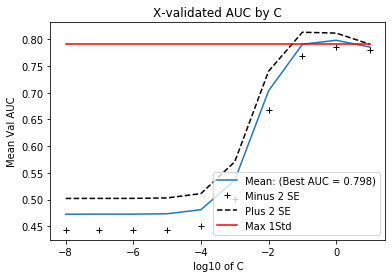

In [42]:
d = {'c':[], 'mean':[], 'se':[]}
for c in cs:
    d['c'].append(c)
    d['mean'].append(np.array(auc_cv[c]).mean()) # mean
    d['se'].append(np.sqrt(np.array(auc_cv[c]).var()/len(auc_cv[c]))) # sqrt(Var(X)/N)

df = pd.DataFrame(d)
df['lower'] = df['mean']-2*df['se']
df['upper'] = df['mean']+2*df['se']
#print(df)

max_1std_m = df['mean'].max()
max_1std_se = float(df[df['mean']==max_1std_m]['se'])
ref = [max_1std_m-max_1std_se]*10
c_lr = df[df['mean']==max_1std_m]['c']
log_c = [np.log10(c) for c in cs]

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(log_c, df['mean'], label = 'Mean: (Best AUC = %0.3f)' % max_1std_m)
plt.plot(log_c, df['lower'], 'k+', label ="Minus 2 SE")
plt.plot(log_c, df['upper'], 'k--', label ="Plus 2 SE")
plt.plot(log_c, ref, 'r', label ="Max 1Std")
plt.legend(loc="lower right")

plt.title('X-validated AUC by C')
ax.set_xlabel('log10 of C')
ax.set_ylabel('Mean Val AUC')

# c=1 is best
#AUC = 0.838

Accuracy of logistic regression classifier on test set: 0.92


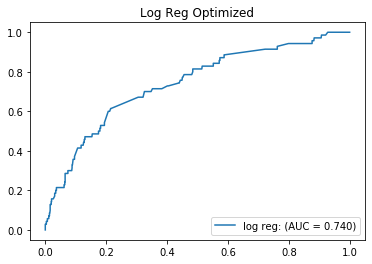

In [43]:
lr1 = LogisticRegression(C=1)
lr1.fit(Xtrain, ytrain) # feature importances from decision tree
y_pred = lr1.predict(Xtest)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr1.score(Xtest, ytest)))

lr_predict1 = lr1.predict_proba(Xtest)[:,1]
lr_fpr, lr_tpr, thresholds = roc_curve(ytest, lr_predict1)
lr_roc_auc = auc(lr_fpr, lr_tpr)

plt.plot(lr_fpr, lr_tpr, label = 'log reg: (AUC = %0.3f)' % lr_roc_auc)
plt.title('Log Reg Optimized')
plt.legend(loc="lower right")

### Log Reg by Cuisine (no optimization or feature selection)


In [44]:
#Run LR for each cuisine with all features

In [46]:
data_cuisine = pd.read_csv('/Users/lisacombs/Documents/FALL2019/INTRO_DS/Project/clean_data/vegas_cuisine.csv')

In [47]:
def run_lr(data, cuisine, feature_select = None, c=1):

  temp = data[data[cuisine] == True]
  
  if feature_select == None:

    X = temp.iloc[:, 16:-1] # confirm cols
    Y = temp['success']
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, train_size = 0.75, random_state = 0)

  else:

    X = temp[feature_select] # confirm cols
    Y = temp['success']
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, train_size = 0.75, random_state = 0)

  lr = LogisticRegression(C=c)
  lr.fit(Xtrain, ytrain) # without feature selection
  # result=logit_model.fit()
  # print(result.summary2())
  y_pred = lr.predict(Xtest)
  print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(Xtest, ytest)))

  lr_predict = lr.predict_proba(Xtest)[:,1]
  lr_fpr, lr_tpr, thresholds = roc_curve(ytest, lr_predict)
  lr_roc_auc = auc(lr_fpr, lr_tpr)

  plt.plot(lr_fpr, lr_tpr, label = cuisine+' LR: (AUC = %0.3f)' % lr_roc_auc)
  plt.title('Log Reg')
  plt.legend(loc="lower right")

  return plt

In [48]:
def run_lasso(data, cuisine, feature_select = None):

  temp = data[data[cuisine] == True]
  
  if feature_select == None:

    X = temp.iloc[:, 16:-1] # confirm cols
    Y = temp['success']
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, train_size = 0.75, random_state = 0)

  else:

    X = temp[feature_select] # confirm cols
    Y = temp['success']
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, train_size = 0.75, random_state = 0)

  lr = LogisticRegression(penalty = 'l1', l1_ratio = 0.5)
  lr.fit(Xtrain, ytrain) # without feature selection
  # result=logit_model.fit()
  # print(result.summary2())
  y_pred = lr.predict(Xtest)
  print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(Xtest, ytest)))

  lr_predict = lr.predict_proba(Xtest)[:,1]
  lr_fpr, lr_tpr, thresholds = roc_curve(ytest, lr_predict)
  lr_roc_auc = auc(lr_fpr, lr_tpr)

  plt.plot(lr_fpr, lr_tpr, label = cuisine+' LR: (AUC = %0.3f)' % lr_roc_auc)
  plt.title('Log Reg')
  plt.legend(loc="lower right")



  return plt

In [49]:
# def run_ridge(data, cuisine, feature_select = None):

#   temp = data[data[cuisine] == True]
  
#   if feature_select == None:

#     X = temp.iloc[:, 16:-1] # confirm cols
#     Y = temp['success']
#     Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, train_size = 0.75, random_state = 0)

#   else:

#     X = temp[feature_select] # confirm cols
#     Y = temp['success']
#     Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, train_size = 0.75, random_state = 0)

#   lr = LogisticRegression(penalty = 'l2')
#   lr.fit(Xtrain, ytrain) # without feature selection
#   # result=logit_model.fit()
#   # print(result.summary2())
#   y_pred = lr.predict(Xtest)
#   print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(Xtest, ytest)))

#   lr_predict = lr.predict_proba(Xtest)[:,1]
#   lr_fpr, lr_tpr, thresholds = roc_curve(ytest, lr_predict)
#   lr_roc_auc = auc(lr_fpr, lr_tpr)

#   plt.plot(lr_fpr, lr_tpr, label = cuisine+' LR: (AUC = %0.3f)' % lr_roc_auc)
#   plt.title('Log Reg')
#   plt.legend(loc="lower right")



#   return plt

Accuracy of logistic regression classifier on test set: 0.89
Accuracy of logistic regression classifier on test set: 0.95
Accuracy of logistic regression classifier on test set: 0.90
Accuracy of logistic regression classifier on test set: 0.82


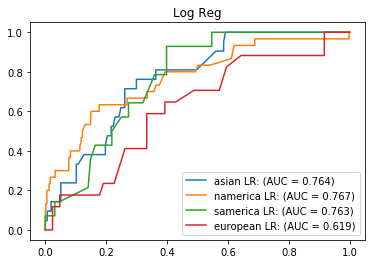

In [50]:
for i in ['asian', 'namerica', 'samerica', 'european']:
  run_lasso(data_cuisine, i)

In [51]:
# for i in ['asian', 'namerica', 'samerica', 'european']:
#   run_ridge(data_cuisine, i)

Accuracy of logistic regression classifier on test set: 0.88
Accuracy of logistic regression classifier on test set: 0.95
Accuracy of logistic regression classifier on test set: 0.89
Accuracy of logistic regression classifier on test set: 0.82


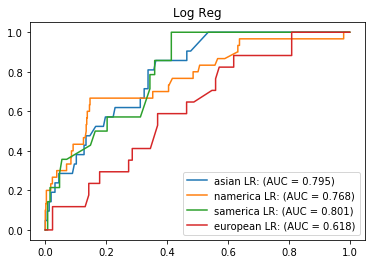

In [52]:
for i in ['asian', 'namerica', 'samerica', 'european']:
  run_lr(data_cuisine, i) # improves slightly for most cuisines

### Log Reg by Cuisine (feature selection, no optimization)

Accuracy of logistic regression classifier on test set: 0.88
Accuracy of logistic regression classifier on test set: 0.95
Accuracy of logistic regression classifier on test set: 0.90
Accuracy of logistic regression classifier on test set: 0.83


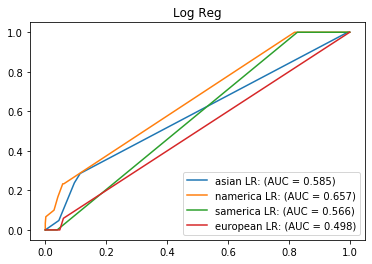

In [53]:
# EXAMPLE:

importantCols = ['Barbeque','BestNights_monday', 'DogsAllowed', 'Desserts']

for i in ['asian', 'namerica', 'samerica', 'european']:
  run_lr(data_cuisine, i, feature_select=importantCols)

In [54]:
#Run LR for each cuisine with features that have less than 50% missing values
data_cuisine.columns.tolist()

['Unnamed: 0',
 'org_index',
 'business_id',
 'name',
 'neighborhood',
 'address',
 'city',
 'state',
 'postal_code',
 'latitude',
 'longitude',
 'stars',
 'review_count',
 'is_open',
 'categories',
 'hours',
 'BusinessAcceptsCreditCards',
 'BusinessParking_garage',
 'BusinessParking_street',
 'BusinessParking_validated',
 'BusinessParking_lot',
 'BusinessParking_valet',
 'GoodForKids',
 'WheelchairAccessible',
 'BikeParking',
 'Alcohol',
 'HasTV',
 'NoiseLevel',
 'RestaurantsAttire',
 'Music_dj',
 'Caters',
 'WiFi',
 'RestaurantsReservations',
 'RestaurantsTakeOut',
 'HappyHour',
 'GoodForDancing',
 'RestaurantsTableService',
 'OutdoorSeating',
 'RestaurantsDelivery',
 'BestNights_monday',
 'BestNights_tuesday',
 'BestNights_friday',
 'BestNights_wednesday',
 'BestNights_thursday',
 'BestNights_sunday',
 'BestNights_saturday',
 'GoodForMeal_dessert',
 'GoodForMeal_latenight',
 'GoodForMeal_lunch',
 'GoodForMeal_dinner',
 'GoodForMeal_breakfast',
 'GoodForMeal_brunch',
 'CoatCheck',
 '

In [55]:
# important_cols = important[7:48]

Accuracy of logistic regression classifier on test set: 0.88
Accuracy of logistic regression classifier on test set: 0.95
Accuracy of logistic regression classifier on test set: 0.90
Accuracy of logistic regression classifier on test set: 0.84


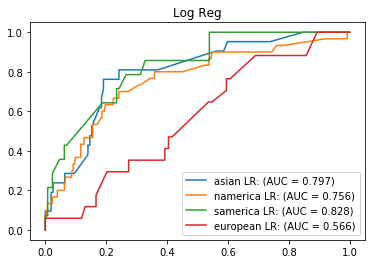

In [56]:
for i in ['asian', 'namerica', 'samerica', 'european']:
  run_lr(datafinal, i, feature_select=important_cols)

In [57]:
#Feature selection

from sklearn.feature_selection import RFE
#Define a function to output important features based on RFE

def get_nfeature(data, cuisine,  nfeatures,feature_select = None):
  temp = data[data[cuisine] == True]
  
  if feature_select == None:

    X = temp.iloc[:, 16:-1] # confirm cols
    Y = temp['success']
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, train_size = 0.75, random_state = 0)

  else:

    X = temp[feature_select] # confirm cols
    Y = temp['success']
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, train_size = 0.75, random_state = 0)
  
  lr = LogisticRegression()
  selector = RFE(lr, n_features_to_select = nfeatures)
  selector = selector.fit( Xtrain,ytrain)

  order = selector.ranking_
  feature_rank = []
  for i in order:
    feature_rank.append(f"{i}.{Xtrain.columns[i]}")

  return feature_rank


In [58]:
feature_rank = get_nfeature(datafinal,'asian',10,feature_select=important_cols)
features_sorted = []

for i in feature_rank:
  if i not in features_sorted:
    features_sorted.append(i)

features_sorted

['20.Food',
 '1.BusinessParking_validated',
 '5.Asian Fusion',
 '26.Hawaiian',
 '14.Caterers',
 '9.Beer',
 '19.Event Planning & Services',
 '28.Juice Bars & Smoothies',
 '30.Nightlife',
 '21.Food Delivery Services',
 '18.Diners',
 '16.Coffee & Tea',
 '2.BusinessParking_valet',
 '13.Casinos',
 '29.Lounges',
 '12.Cafes',
 '24.Gluten-Free',
 '4.Arts & Entertainment',
 '3.class',
 '22.Food Stands',
 '15.Cocktail Bars',
 '23.Food Trucks',
 '7.Barbeque',
 '6.Bakeries',
 '11.Buffets',
 '27.Ice Cream & Frozen Yogurt',
 '31.Pubs',
 '17.Desserts',
 '10.Breakfast & Brunch',
 '32.Restaurants',
 '8.Bars',
 '25.Grocery']

In [59]:
# import statsmodels.api as sm

# def run_sm(data, cuisine, feature_select = None):
#   temp = data[data[cuisine] == True]
  
#   if feature_select == None:

#     X = temp.iloc[:, 16:-1] # confirm cols
#     Y = temp['success']
#     Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, train_size = 0.75, random_state = 0)

#   else:

#     X = temp[feature_select] # confirm cols
#     Y = temp['success']
#     Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, train_size = 0.75, random_state = 0)

#   lr = LogisticRegression()
#   lr.fit(Xtrain, ytrain) # without feature selection

#   logit_model=sm.Logit(ytrain,Xtrain)
#   result=logit_model.fit()
#   print(result.summary2())  

#   # y_pred = lr.predict(Xtest)
#   # print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(Xtest, ytest)))

In [60]:
# run_sm(datafinal, 'asian', feature_select = important_cols)

### LR by cuisine with feature selection and optimization:

In [61]:
# Find the optimal C: 

cs = [10**c for c in range(-8, 2)]
auc_cv = {c:[] for c in cs}
kf = KFold(n_splits=5, random_state=1) 

d=datafinal[datafinal['namerica'] == True].iloc[:,16:]

for train_set_kf, val_set_kf in kf.split(d): 
  cv_train, cv_validate = d.iloc[train_set_kf], d.iloc[val_set_kf]
  X_train, X_test = cv_train.drop('success',1), cv_validate.drop('success',1)
  y_train, y_test = cv_train['success'].astype('int'), cv_validate['success'].astype('int')

  for c in cs:
    #print(c)
  
    lr = LogisticRegression(C=c)
    lr_fit = lr.fit(X_train, y_train)
    lr_preds = lr_fit.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test,lr_preds)

    #print(auc(fpr,tpr))

    auc_cv[c].append(auc(fpr,tpr))

print(auc_cv)


{1e-08: [0.34625, 0.30935706643322636, 0.35851685393258426, 0.347191011235955, 0.3796775536914749], 1e-07: [0.34625, 0.30950296663748655, 0.35856179775280894, 0.34723595505617977, 0.3799750133856863], 1e-06: [0.34625, 0.30950296663748655, 0.35856179775280894, 0.34723595505617977, 0.3799750133856863], 1e-05: [0.34624999999999995, 0.3095029666374866, 0.35856179775280894, 0.3473258426966292, 0.38003450532452854], 0.0001: [0.3482954545454545, 0.30989203384884734, 0.3590112359550562, 0.3480449438202247, 0.38051044083526686], 0.001: [0.3539015151515152, 0.31611710923061953, 0.3633258426966292, 0.35253932584269665, 0.38396097328811946], 0.01: [0.4504166666666667, 0.515805855461531, 0.5493932584269663, 0.542561797752809, 0.4921768100422393], 0.1: [0.7985227272727272, 0.8115942028985508, 0.8092584269662922, 0.7656629213483146, 0.7639359866738057], 1: [0.8114015151515152, 0.8093570664332262, 0.7968539325842696, 0.7512808988764045, 0.8001665774287584], 10: [0.7940530303030304, 0.7455500437700613,

In [62]:
# Find the optimal C: 

def optimal_c(cusine_type):
  cs = [10**c for c in range(-8, 2)]
  auc_cv = {c:[] for c in cs}
  kf = KFold(n_splits=5, random_state=1) 

  d=datafinal[datafinal[cusine_type] == True].iloc[:,16:]

  for train_set_kf, val_set_kf in kf.split(d): 
    cv_train, cv_validate = d.iloc[train_set_kf], d.iloc[val_set_kf]
    X_train, X_test = cv_train.drop('success',1), cv_validate.drop('success',1)
    y_train, y_test = cv_train['success'].astype('int'), cv_validate['success'].astype('int')

    for c in cs:
      #print(c)
    
      lr = LogisticRegression(C=c)
      lr_fit = lr.fit(X_train, y_train)
      lr_preds = lr_fit.predict_proba(X_test)[:,1]
      fpr, tpr, thresholds = roc_curve(y_test,lr_preds)

      #print(auc(fpr,tpr))

      auc_cv[c].append(auc(fpr,tpr))

  return auc_cv

def optimal_c_plot(auc_cv):
  d = {'c':[], 'mean':[], 'se':[]}
  for c in cs:
      d['c'].append(c)
      d['mean'].append(np.array(auc_cv[c]).mean()) # mean
      d['se'].append(np.sqrt(np.array(auc_cv[c]).var()/len(auc_cv[c]))) # sqrt(Var(X)/N)

  df = pd.DataFrame(d)
  df['lower'] = df['mean']-2*df['se']
  df['upper'] = df['mean']+2*df['se']
  #print(df)
  optim_c_val = df.iloc[np.where(df['mean']==df['mean'].max())]['c']
  print('The optimal c value = %0.1f' %optim_c_val)


  max_1std_m = df['mean'].max()
  max_1std_se = float(df[df['mean']==max_1std_m]['se'])
  ref = [max_1std_m-max_1std_se]*10
  c_lr = df[df['mean']==max_1std_m]['c']
  log_c = [np.log10(c) for c in cs]

  fig = plt.figure()
  ax = fig.add_subplot(111)

  plt.plot(log_c, df['mean'], label = 'Mean: (Best AUC = %0.3f)' % max_1std_m)
  plt.plot(log_c, df['lower'], 'k+', label ="Minus 2 SE")
  plt.plot(log_c, df['upper'], 'k--', label ="Plus 2 SE")
  plt.plot(log_c, ref, 'r', label ="Max 1Std")
  plt.legend(loc="lower right")
  #print(df)

  #plt.title('X-validated AUC by C')
  ax.set_xlabel('log10 of C')
  ax.set_ylabel('Mean Val AUC')

The optimal c value = 1.0


Text(0.5, 1.0, 'X-validated AUC by C: namerica')

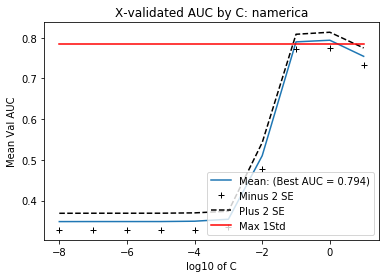

In [63]:
na_c = optimal_c('namerica')
optimal_c_plot(na_c)
plt.title('X-validated AUC by C: namerica')

The optimal c value = 1.0
The optimal c value = 1.0
The optimal c value = 1.0
The optimal c value = 1.0


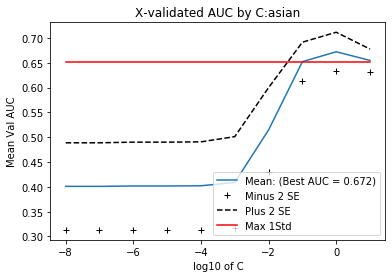

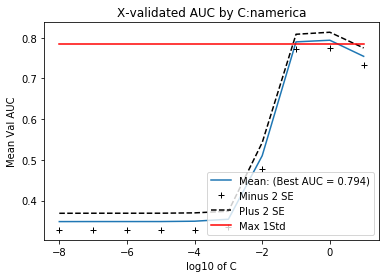

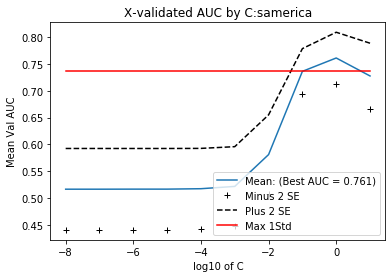

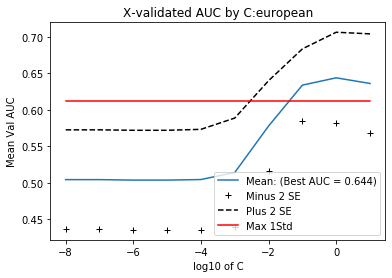

In [64]:
#loop
for i in ['asian', 'namerica', 'samerica', 'european']:
  temp = optimal_c(i)
  optimal_c_plot(temp)
  plt.title('X-validated AUC by C:%s' %i)

#NOTE: 1 has been added as a parameter to the function above!

### Bootstrapping for LR

In [66]:
import random 
import matplotlib
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, roc_auc_score

%matplotlib inline

data = pd.read_csv('/Users/lisacombs/Documents/FALL2019/INTRO_DS/Project/clean_data/vegas_cuisine.csv')
data_train, data_test = train_test_split(data, train_size = 0.75, random_state = 0)

In [67]:
data_train.shape

(2834, 422)

In [68]:
cuisine = ['asian','namerica','samerica','european']

In [69]:
#general
samplesizes = [50, 100, 200, 500, 1000, 1500, 2000,2500,3000]

def modBootstrapper(train, test, nruns, sampsize, c):
    auc = []
    for i in range(nruns):
        train_samp = train.sample(n = sampsize, replace=True)
        
        x_train = train_samp[important_cols]
        y_train = train_samp['success']
        
        x_test = test[important_cols]
        y_test = test['success']
        
        LR = LogisticRegression(solver ='lbfgs')
        LR.fit(x_train, y_train)
        y_pred_proba_LR = LR.predict_proba(x_test)[:,1]
        roc_auc = roc_auc_score(y_test, y_pred_proba_LR)

          
        auc.append(roc_auc)
    
    auc_mean = np.mean(auc)
    auc_std = np.sqrt(np.var(auc))
    aucs = [auc_mean, auc_std]
    return aucs

In [72]:
#Choose C= 1 found above

C = 1
nruns = 20

def learning_curve(samplesizes,nruns,data_train,data_test,C):
  auc_mean_LR = []
  auc_mean_minus2std_LR =[]
  auc_mean_plus2std_LR =[]
  xs = np.log2(samplesizes)

  for i in samplesizes:
      auc_mean0, auc_std0 = modBootstrapper(data_train, data_test, nruns, i, C)
      auc_mean_LR.append(auc_mean0)
      auc_mean_minus2std_LR.append(auc_mean0 - 2*auc_std0)
      auc_mean_plus2std_LR.append(auc_mean0 + 2*auc_std0)

    
  %matplotlib inline

  fig = plt.figure(figsize = (12, 6))
  ax = plt.subplot(111)

  plt.title('Bootstrapped AUC + Confidence Limits \n as a Function of N Samples')
  plt.plot(xs, auc_mean_LR, 'b', label ='Average AUC for LR')
  plt.plot(xs, auc_mean_minus2std_LR, 'b+', label ='Lower 95% CI for LR')
  plt.plot(xs, auc_mean_plus2std_LR, 'b--', label ='Upper 95% CI for LR')
  plt.xlim([min(xs),max(xs)])       
  plt.xlabel('Log2(N)')
  plt.ylabel('Test Set AUC')
  plt.legend(loc="lower right")

Bootstrapping for each cuisine

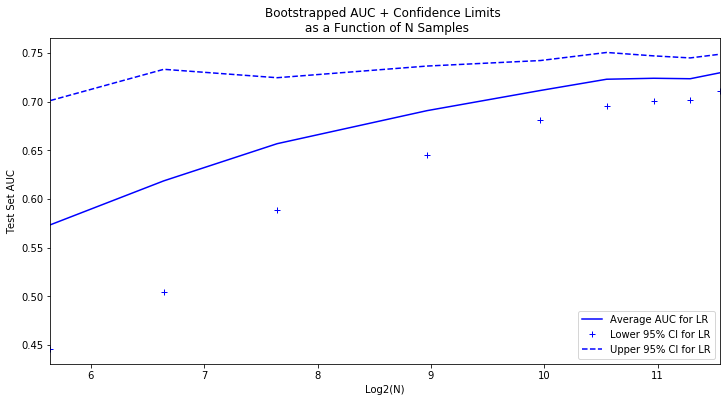

In [73]:
learning_curve(samplesizes,nruns,data_train,data_test,C)

In [74]:
#Create a training and testing set for each cuisine

dtrain_A, dtest_A = data_train[data_train['asian']==True], data_test[data_test['asian']==True]
dtrain_E, dtest_E = data_train[data_train['european']==True], data_test[data_test['european']==True]
dtrain_NA, dtest_NA = data_train[data_train['namerica']==True], data_test[data_test['namerica']==True]
dtrain_SA, dtest_SA = data_train[data_train['samerica']==True], data_test[data_test['samerica']==True]

dtrain_A.shape, dtrain_E.shape, dtrain_NA.shape, dtrain_SA.shape
# learning_curve(samplesizes,nruns,data_train,data_test,C)

((535, 422), (298, 422), (1755, 422), (433, 422))

Asian


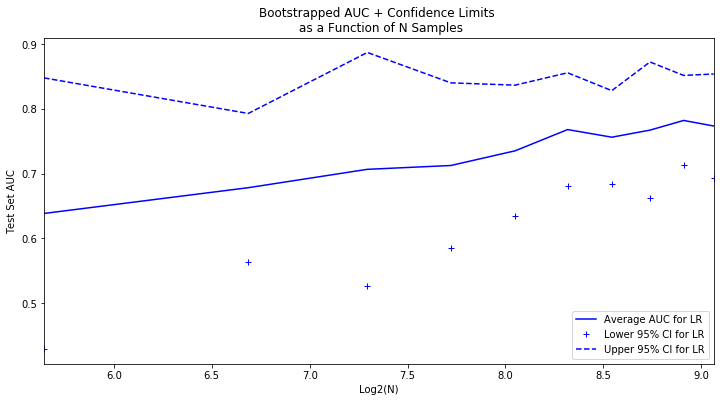

In [75]:
samplesizesA = [int(i) for i in np.linspace(50,535,10)]
samplesizesE = [int(i) for i in np.linspace(50,298,10)]
samplesizesNA = [int(i) for i in np.linspace(50,1755,10)]
samplesizesSA = [int(i) for i in np.linspace(50,433,10)]

print('Asian')
learning_curve(samplesizesA,nruns,dtrain_A,dtest_A,C)

European


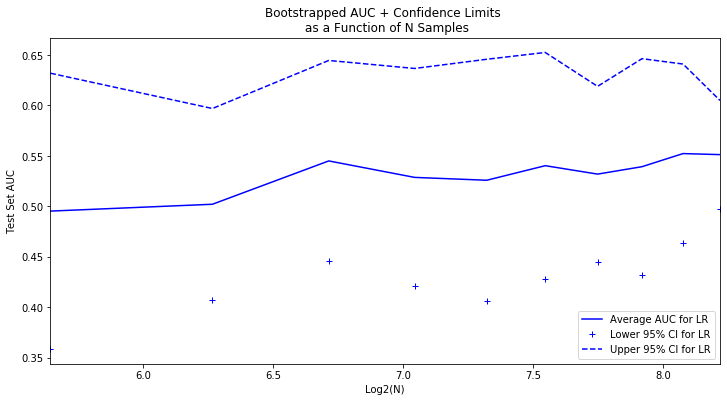

In [76]:
print('European')
learning_curve(samplesizesE,nruns,dtrain_E,dtest_E,C)

North America


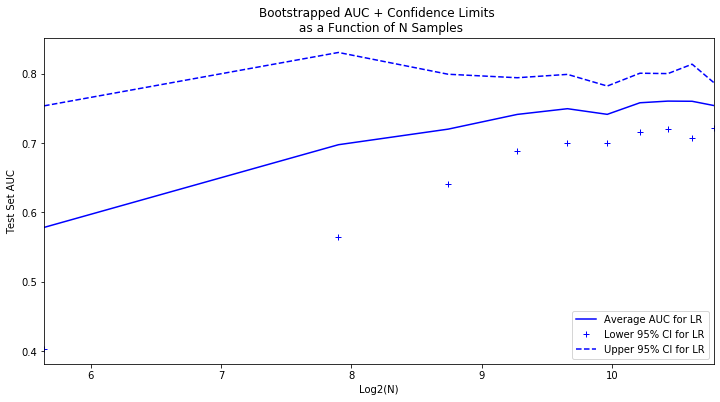

In [77]:
print('North America')
learning_curve(samplesizesNA,nruns,dtrain_NA,dtest_NA,C)

South America


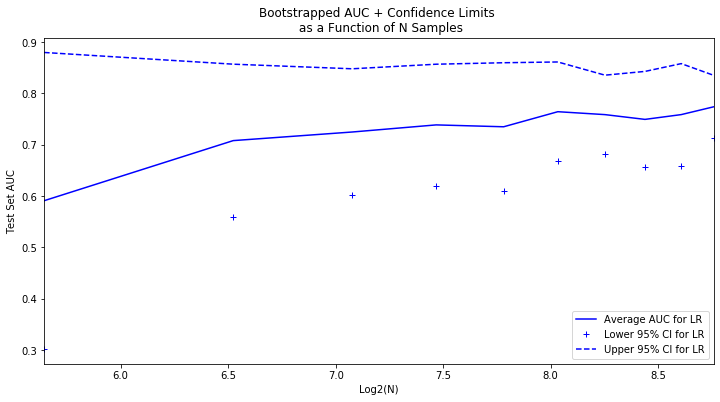

In [78]:
print('South America')
learning_curve(samplesizesSA,nruns,dtrain_SA,dtest_SA,C)

### ROC Curve of all models

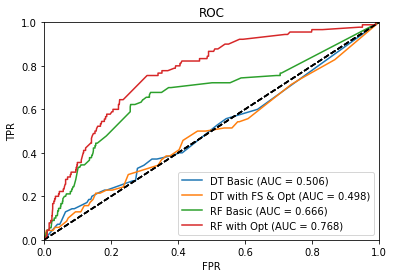

In [79]:
def plotAUC(truth, pred, lab):
    fpr, tpr, thresholds = roc_curve(truth, pred)
    
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label= lab+' (AUC = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
plotAUC(ytest, dt_predict, 'DT Basic')
plotAUC(ytest, dt_predict_opt2, 'DT with FS & Opt')
plotAUC(ytest_rf, rf_predict, 'RF Basic')
plotAUC(ytest_rf, rf_predict1, 'RF with Opt')
# plotAUC(ytest, lr_predict, 'LR Basic')

plt.show()